# HarvestStat Data Profiling - Zimbabwe

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32736' # Zimbabwe
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/ZW_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Zimbabwe',
    'product': ['R011','R012','R013','R014','R015','R017','R018'],
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint,params=parameters, proxies={})# auth=auth, 
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #
print(df.shape)

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1981	 | ZW1981A1 | 8	| ZW1981A2	| 58	| nan	| 0	|
| 2007	 | ZW2007A1 | 10	| ZW2007A2	| 84	| nan	| 0	|
| 2008	 | ZW2008A1 | 10	| ZW2008A2	| 84	| nan	| 0	|
| 2009	 | ZW2009A1 | 10	| ZW2009A2	| 85	| nan	| 0	|
| 2011	 | ZW2011A1 | 10	| ZW2011A2	| 89	| nan	| 0	|
| 2018	 | ZW2018A1 | 10	| ZW2018A2	| 89	| nan	| 0	|
----------------------------------------------- #
(96960, 58)


In [9]:
# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ZW_Admin1_2011], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = ZW_Admin1_2011.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

../figures/ZW_admin_shapes.png is saved.


- Zimbabwe crop seasonal calendar

![FEWS NET](../figures/crop_calendar/seasonal-calendar-zimbabwe.png)
<img src="../figures/crop_calendar/Zimbabwe_-_Crop_calendar.jpg"  width="60%">

- FDW data consists of `ZW2011A2`.

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1981	 | ZW1981A1 | 8	| ZW1981A2	| 58	|
| 2007	 | ZW2007A1 | 10	| ZW2007A2	| 84	|
| 2008	 | ZW2008A1 | 10	| ZW2008A2	| 84	|
| 2009	 | ZW2009A1 | 10	| ZW2009A2	| 85	|
| 2011	 | ZW2011A1 | 10	| **`ZW2011A2`**	| 89	|

- Comparison between admin boundaries.

<img src="../figures/ZW_admin_shapes.png"  width="60%">

In [10]:
# Load data from the admin-1 level auxiliary data
df = pd.read_excel('../data/auxiliary/zimbabwe/GSCD_Zimbabwe_Maize_Production.xlsx', sheet_name='Sheet1', header=[0,1], index_col=0).T
area, prod = df.loc['Area'], df.loc['Production']
assert all(area.isna() == prod.isna())
crop = prod / area
area = area.stack().reset_index()
area.columns = ['year', 'province', 'value']
area['indicator'] = 'area'
prod = prod.stack().reset_index()
prod.columns = ['year', 'province', 'value']
prod['indicator'] = 'production'
crop = crop.stack().reset_index()
crop.columns = ['year', 'province', 'value']
crop['indicator'] = 'yield'
df = pd.concat([area, prod, crop], axis=0)
# Exclude total
df = df[df['province'] != 'Total']
# Modify years
df['harvest_year'] = df['year'].apply(lambda x: int(x.split('-')[1]))
df['harvest_month'] = 0
df['planting_year'] = df['harvest_year']
df['planting_month'] = 0
# FNID and country names
fnid_dict = {
    'Mashonaland West': 'ZW2011A114', 
    'Mashonaland Central' : 'ZW2011A112', 
    'Mashonaland East': 'ZW2011A113',
    'Manicaland' : 'ZW2011A111', 
    'Midlands' : 'ZW2011A117', 
    'Masvingo' : 'ZW2011A118', 
    'Matabeleland North' : 'ZW2011A115',
    'Matabeleland South' : 'ZW2011A116'
}
df['fnid'] = df['province'].apply(lambda x: fnid_dict[x])
df['country'] = 'Zimbabwe'
df['country_code'] = 'ZW'
df = df.rename(columns = {'province': 'admin_1'})
df['admin_2'] = np.nan
df['name'] = df['admin_1']
# Other variables
df['product'] = 'Maize'
df['season_name'] = 'Main'
df['crop_production_system'] = 'none'
df['gscd_code'] = 'calibrated'
# Organize columns
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = df[names]
# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {'Maize':'Maize'}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Zimbabwe']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_ZW.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_ZW.csv is saved.


# Visualization of production data

../figures/ZW_bar_natgrainprod_Main.png is saved.


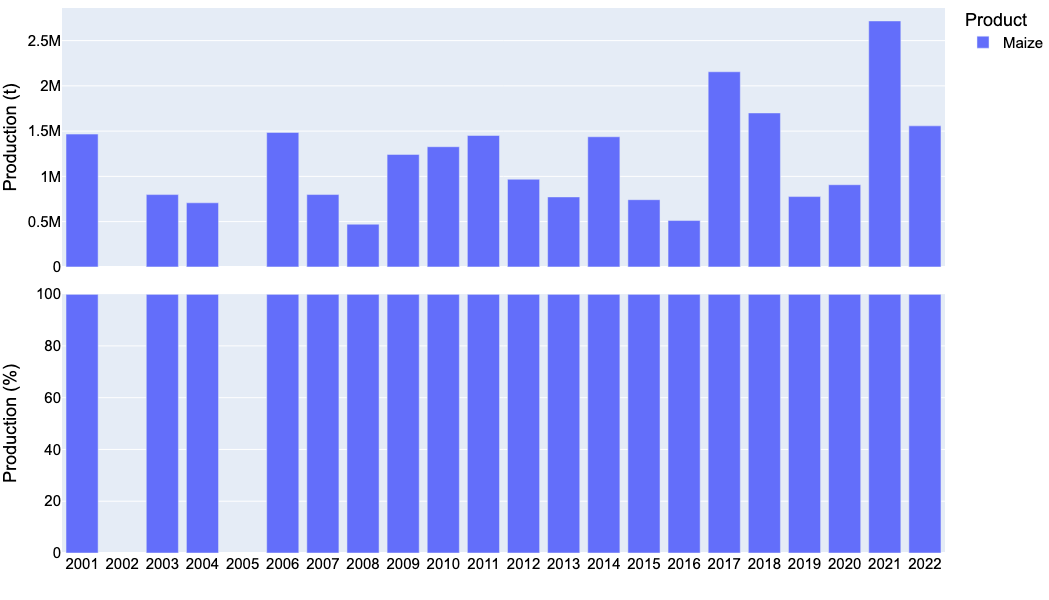

In [11]:
# Bar chart of national crop production
country_iso, country_name = 'ZW', 'Zimbabwe'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize']
for season_name in ['Main']:
    footnote = 'National crop production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

../figures/ZW_line_pay_Maize_Main.png is saved.


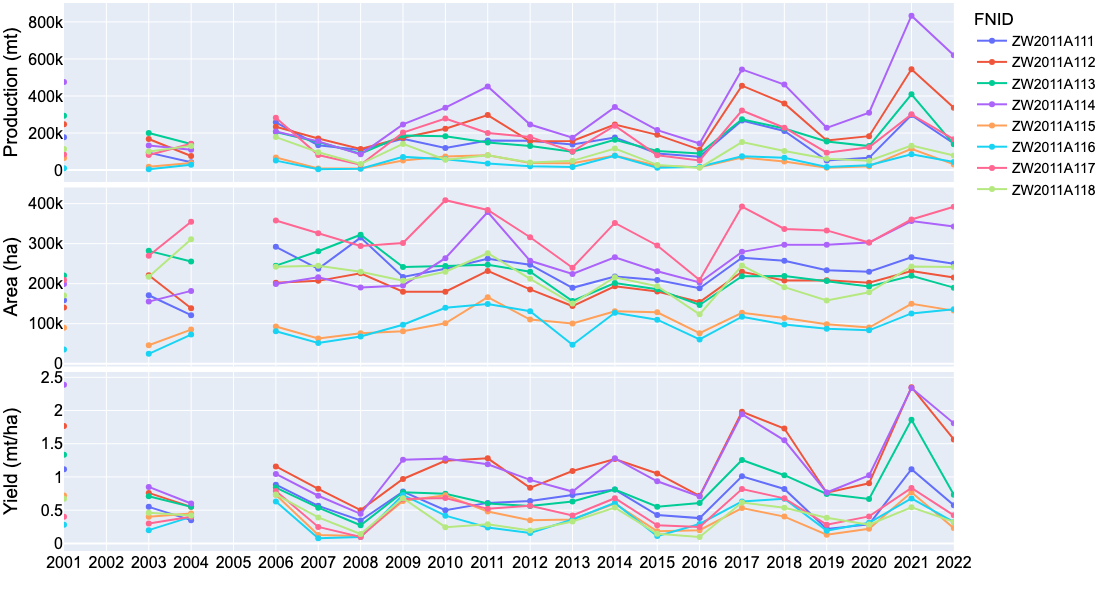

In [12]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'ZW', 'Zimbabwe'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()